## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [19]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [20]:
train, test = keras.datasets.cifar10.load_data()

In [21]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [22]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [23]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 128, 64]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [24]:
LEARNING_RATE = 1e-3
EPOCHS = 15 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [25]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3,0.8]
redice_lr_patient = [3,8]

In [26]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s-%s-%s" % (optim,reduce_factor,reduce_patient))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_118 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_119 (Bat (None, 128)               512       
_________________________________________________________________
hidden_layer3 (Dense)        (None, 64)                8256      
_________________________________________________________________
batch_normalizatio

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 7s 142us/step - loss: 2.2327 - acc: 0.2390 - val_loss: 2.2589 - val_acc: 0.2721
Epoch 2/15
50000/50000 [==============================] - 2s 45us/step - loss: 1.8232 - acc: 0.3569 - val_loss: 1.9242 - val_acc: 0.3397
Epoch 3/15
50000/50000 [==============================] - 2s 50us/step - loss: 1.7049 - acc: 0.3985 - val_loss: 1.7635 - val_acc: 0.3841
Epoch 4/15
50000/50000 [==============================] - 2s 45us/step - loss: 1.6344 - acc: 0.4242 - val_loss: 1.6991 - val_acc: 0.4040
Epoch 5/15
50000/50000 [==============================] - 2s 44us/step - loss: 1.5841 - acc: 0.4418 - val_loss: 1.6469 - val_acc: 0.4204
Epoch 6/15
50000/50000 [==============================] - 2s 45us/step - loss: 1.5416 - acc: 0.4576 - val_loss: 1.6230 - val_acc: 0.4207
Epoch 7/15
50000/50000 [==============================] - 2s 44us/step - loss: 1.5060 - acc: 0.4704 - val_loss: 1.6049 - val_ac

50000/50000 [==============================] - 2s 47us/step - loss: 1.1897 - acc: 0.5816 - val_loss: 2.1211 - val_acc: 0.3406

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 9/15
50000/50000 [==============================] - 2s 47us/step - loss: 1.1016 - acc: 0.6156 - val_loss: 1.4780 - val_acc: 0.4783
Epoch 10/15
50000/50000 [==============================] - 2s 47us/step - loss: 1.0640 - acc: 0.6300 - val_loss: 1.4273 - val_acc: 0.4954
Epoch 11/15
50000/50000 [==============================] - 2s 47us/step - loss: 1.0399 - acc: 0.6392 - val_loss: 1.4288 - val_acc: 0.4944
Epoch 12/15
50000/50000 [==============================] - 2s 48us/step - loss: 1.0233 - acc: 0.6456 - val_loss: 1.5107 - val_acc: 0.4798
Epoch 13/15
50000/50000 [==============================] - 2s 48us/step - loss: 1.0034 - acc: 0.6517 - val_loss: 1.4430 - val_acc: 0.4993

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 14/15
50000/50000

50000/50000 [==============================] - 2s 47us/step - loss: 1.1489 - acc: 0.6051 - val_loss: 1.4666 - val_acc: 0.4864
Epoch 15/15
50000/50000 [==============================] - 2s 47us/step - loss: 1.1323 - acc: 0.6134 - val_loss: 1.4706 - val_acc: 0.4761
Numbers of exp: 7, reduce_factor: 0.80, reduce_patient: 8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_139 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 8s 169us/step - loss: 1.8713 - acc: 0.3574 - val_loss: 1.9850 - val_acc: 0.3244
Epoch 2/15
50000/50000 [==============================] - 2s 46us/step - loss: 1.6034 - acc: 0.4416 - val_loss: 1.9936 - val_acc: 0.3433
Epoch 3/15
50000/50000 [==============================] - 2s 46us/step - loss: 1.5067 - acc: 0.4730 - val_loss: 1.7869 - val_acc: 0.3691
Epoch 4/15
50000/50000 [==============================] - 2s 46us/step - loss: 1.4404 - acc: 0.4976 - val_loss: 2.0400 - val_acc: 0.2923
Epoch 5/15
50000/50000 [==============================] - 2s 49us/step - loss: 1.3856 - acc: 0.5162 - val_loss: 1.7384 - val_acc: 0.3788
Epoch 6/15
50000/50000 [==============================] - 2s 46us/step - loss: 1.3419 - acc: 0.5304 - val_loss: 1.6875 - val_acc: 0.4096
Epoch 7/15
50000/50000 [==============================] - 2s 49us/step - loss: 1.3041 - acc: 0.5453 - val_loss: 2.7194 - val_ac

50000/50000 [==============================] - 2s 45us/step - loss: 1.3424 - acc: 0.5277 - val_loss: 2.0832 - val_acc: 0.3334
Epoch 8/15
50000/50000 [==============================] - 2s 46us/step - loss: 1.3095 - acc: 0.5436 - val_loss: 1.6505 - val_acc: 0.4296
Epoch 9/15
50000/50000 [==============================] - 2s 46us/step - loss: 1.2779 - acc: 0.5540 - val_loss: 1.8418 - val_acc: 0.3750
Epoch 10/15
50000/50000 [==============================] - 2s 45us/step - loss: 1.2526 - acc: 0.5643 - val_loss: 1.9617 - val_acc: 0.3503
Epoch 11/15
50000/50000 [==============================] - 2s 46us/step - loss: 1.2256 - acc: 0.5749 - val_loss: 1.5595 - val_acc: 0.4594
Epoch 12/15
50000/50000 [==============================] - 2s 45us/step - loss: 1.2029 - acc: 0.5825 - val_loss: 1.7993 - val_acc: 0.3919
Epoch 13/15
50000/50000 [==============================] - 2s 45us/step - loss: 1.1817 - acc: 0.5898 - val_loss: 1.5517 - val_acc: 0.4618
Epoch 14/15
50000/50000 [=======================

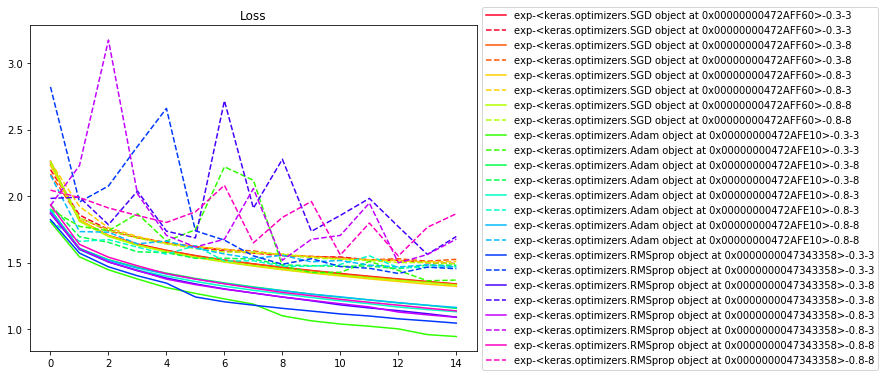

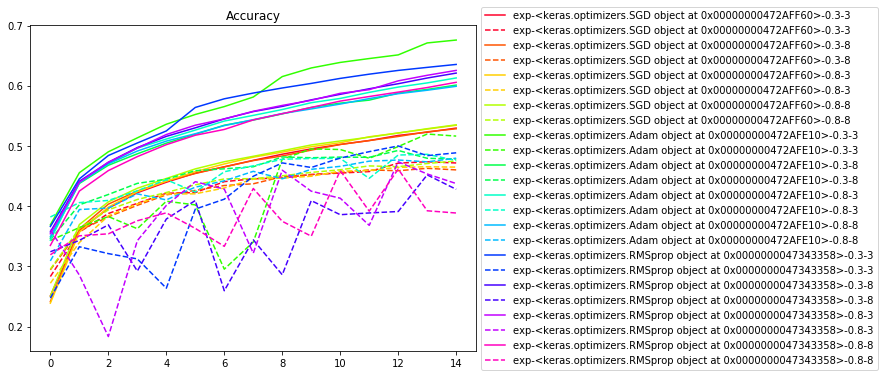

In [27]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()